# Call center data modeling

## 1. Compute a 98% posterior confidence interval over the number of calls per minute (the call rate λ ) for each hour of the day — so you will have 24 confidence intervals. Also, compute the posterior mean of λ for each hour of the day.

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('call_center.csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# # Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


In the code below, I followed the template during the in-class activity, which means I chose the gamma distribution paremeterized by $\alpha=1$ and $\beta=0.1$ as the likelihood for **all** hours. However, I just want to point out this is not the only option we have. We could even choose a different prior for each hout. Some factors that can influence our choice of prior:

1. The support of the distribution. (Here gamma distribution makes sense in this respect as its support is positive real number, fitting lambda, the rate of calls).
2. The different values lambdas can take, or its typical range."

In [3]:
# THE LIKELIHOOD FUNCTION
#
# This function takes 2 inputs, namely the parameter (λ) value at which to
# compute the likelihood and a value from the data set. You need to evaluate
# the exponential distribution of the datum given the parameter value.

def likelihood(lambda_, datum):
    """
    We calculate P(datum | lambda_, exponential),
    which is the exponential's pdf evaluated at datum.
    """
    return sts.expon(scale=1/lambda_).pdf(datum)

# THE PRIOR DISTRIBUTION
#
# This function takes 1 input, namely the parameter value (λ) at which to
# compute the prior probability density. You need to evaluate the distribution
# Gamma(λ | α, β).

def prior(lambda_):
    """
    Prior is the gamma distribution with alpha = 1 and beta=0.25 over values
    of lambda. 
    The input is a value of lambda, and the output is the gamma's pdf evaluated
    at lambda.
    """
    return sts.gamma(1, scale=1/0.25).pdf(lambda_)

# THE POSTERIOR DISTRIBUTION
#
# The function below is provided to help make computing the posterior easier. It
# follows the same pattern as in the previous class, where we multiple the prior
# and the likelihood evaluated at various values of the parameter (λ).
#
# You will see the function uses the logarithms of various distributions. This
# is for numerical reasons. When you multiply lots of likelihood values, the
# result can become very large or very small, causing numerical overflow or
# underflow in Python. Taking logarithms avoids this problem.

def compute_posterior(parameter_values, prior, likelihood, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

def compute_percentile(parameter_values, distribution_values, percentile):
    '''
    Compute the parameter value at a particular percentile of the given
    probability distribution values. This function uses the cumulative trapezoid
    integrator in SciPy.

    Inputs:

        parameter_values (array of float) This is the list of parameter values
          at which the probability distribution has been evaluated.

        distribution_values (array of float) This is the list of values of the
          probability density function evaluated at the parameter values above.

        percentile (float) This is the value between 0 and 1 of the percentile
          to compute.

    Returns: (float) The parameter value at the given percentile.
    '''
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    return lambdas[percentile_index]

# posterior_means = []
percentiles_list = []
for hour_index in range(24):
    waiting_times_hour = waiting_times_per_hour[hour_index]
    lambdas = np.linspace(0, 20, 501)[1:]
    posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_hour)
#     lambda_ = sp.integrate.trapz(posterior * lambdas, lambdas)
#     posterior_means.append(lambda_)
    percentiles = [compute_percentile(lambdas, posterior, p) for p in [0.01, 0.99]]
    percentiles_list.append(percentiles)
    
    print(percentiles)

[0.04, 0.2]
[0.04, 0.16]
[0.04, 0.16]
[0.08, 0.44]
[0.24, 0.64]
[0.6, 1.2]
[1.2, 1.96]
[2.36, 3.4]
[3.64, 4.88]
[5.0, 6.44]
[7.4, 9.16]
[14.16, 16.52]
[13.120000000000001, 15.4]
[5.6000000000000005, 7.12]
[2.56, 3.64]
[2.88, 4.0]
[3.7600000000000002, 5.0]
[6.2, 7.76]
[7.92, 9.68]
[5.88, 7.44]
[1.84, 2.7600000000000002]
[0.56, 1.12]
[0.16, 0.52]
[0.12, 0.48]


## 2. Present your results graphically using Matplotlib. Make a plot that looks like the one below. Each dot is at the posterior mean and each line shows a 98% confidence interval for a λ. You can use the errorbar() function in the plotting library to do this

Text(0,0.5,'Call rate (calls per minute)')

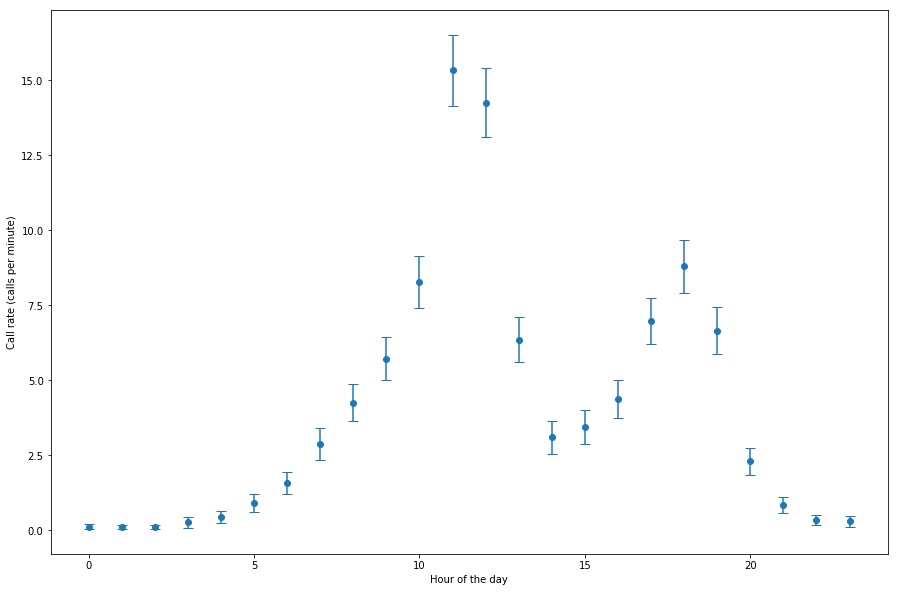

In [4]:
# Get the posterior expected values of λ
posterior_means = []
for interval in percentiles_list:
    # the mean (the expection) is the middle point of the interval (the 50% percentile).
    # which is the average of the two ends of the interval
    posterior_means.append((interval[0]+interval[1])/2)

# plot it!
plt.figure(figsize=(15,10))
plt.errorbar(range(24), posterior_means, 
             [(interval[1]-interval[0])/2 for interval in percentiles_list],
            fmt='o', capsize=5)
plt.xlabel('Hour of the day')
plt.ylabel('Call rate (calls per minute)')

## 3. Write a paragraph (100–200 words) to accompany your plot and present your findings to the client. Carefully summarize how many calls you expect during different parts of the day, and how much uncertainty there is in your estimates. Remember that the client is not an expert in statistics, so make it easy for them to understand. You may also make additional plots to help communicate your results.

The x-axis shows 24 hours of the day. Corresponding to each hour is a range for the number of calls per minute during that hour, which is shown on the y-axis. This range tells us that we are 98% confident (meaning that we are highly condifent, although not we are not absolutely sure with a 100% level of confidence) that the number of calls per minute during that hour would fall somewhere in this range. Therefore, the smaller the range (like those for hours 0, 1, 2), the more certain we are about the number of calls per minute being around the mean (the dot in each range.)

During the night (from hour 21 to hour 5), we expect that the number of calls per minute is really low (from just barely above 0 to just below 1 call), and we are highly certain about these estimates, as reflected in the narrowness of the bars for these hours. After hour 5, the there's also an increase in the uncertainty in the estimates. The number of calls peaks at hour 11 (at around 15). After mid-day, there's another peak at hour 18 then the number of calls decreases steadily towards the end of the day.

Generally speaking, the certainty surrounding our estimates is high for night-time hours (21 to 5), but relatively low for the rest of the day (the highest uncertainty is at hour 11). Therefore, for deciding on the number of call agents for the night shifts, you can safely rely on the expected number of calls we estimated. However, any decision based on the expected numbers of calls per minute for the rest of the day needs to take into consideration the high uncertainty surrounding the estimates.